In [1]:
pip install python-chess

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.1/6.1 MB 50.9 MB/s eta 0:00:0000:0100:01
  Preparing metadata (setup.py) ... done
  Created wheel for chess: filename=chess-1.11.2-py3-none-any.whl size=147776 sha256=be4eacd4747e95e3066ddaebdf0c1d4c26063c854a0f0f460f6bb7c883bcc6ed
  Stored in directory: /root/.cache/pip/wheels/7a/79/8e/0d6e404db9f1e82af2e40b49161d6acab485d75dfb0470ac08
Successfully built chess
Note: you may need to restart the kernel to use updated packages.


In [2]:

# Importing necessary libraries, including `matplotlib` for plots and `sklearn` for easy data splitting.

# %% {"cell_type": "code"}
import os
import numpy as np
import time
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from chess import Board, pgn, Move, flip_horizontal # Board has SVG capabilities!
from tqdm.notebook import tqdm # Use notebook version for better display
import pickle
import gc # Garbage collector interface
import matplotlib.pyplot as plt # For plotting graphs
import random
from sklearn.model_selection import train_test_split # For easy data splitting!
from IPython.display import display, SVG # To display SVG output

print("Imports successful!")


Imports successful!


In [ ]:
!rm output.zip


In [3]:
# ## Cell 2: Auxiliary Functions (Board Rep, Data Gen, Move Encoding)
# Contains helpers for board representation, the iterative data generator (now just generates all data before splitting), move encoding, and ELO parsing. Data augmentation logic is included.

# %% {"cell_type": "code"}
def board_to_matrix_v4(board: Board, flip: bool = False):
    """
    Converts a board state into a matrix representation (multi-channel).
    Version 4: Includes piece positions, turn, castling rights, and optional horizontal flip.
    Input features are consistent with V3.

    Output shape: (18, 8, 8) - float32 numpy array
    Channels:
    - 0-5: White pieces (P, N, B, R, Q, K)
    - 6-11: Black pieces (P, N, B, R, Q, K)
    - 12: White King Castling Right (1 if True)
    - 13: White Queen Castling Right (1 if True)
    - 14: Black King Castling Right (1 if True)
    - 15: Black Queen Castling Right (1 if True)
    - 16: White's Turn (1 if White's turn)
    - 17: Constant plane of 1s
    """
    matrix = np.zeros((18, 8, 8), dtype=np.float32)
    current_board = board.copy() # Work on a copy to avoid modifying the original board

    # Apply flip transformation if requested
    if flip:
        # chess.flip_horizontal is a transformation constant, apply it via board.transform
        # This flips pieces, turn, en passant square, but NOT castling rights inherently.
        current_board = current_board.transform(flip_horizontal)

    # Populate piece layers based on the (potentially flipped) board state
    piece_map = current_board.piece_map()
    for square, piece in piece_map.items():
        row, col = divmod(square, 8)
        piece_idx = piece.piece_type - 1
        color_offset = 0 if piece.color else 6 # White=0, Black=6
        matrix[piece_idx + color_offset, row, col] = 1

    # Populate castling rights layers (use ORIGINAL board's perspective)
    # Castling rights are relative to the initial setup, flipping the board doesn't change
    # whether White *originally* had kingside rights, etc.
    if board.has_kingside_castling_rights(True): matrix[12, :, :] = 1
    if board.has_queenside_castling_rights(True): matrix[13, :, :] = 1
    if board.has_kingside_castling_rights(False): matrix[14, :, :] = 1
    if board.has_queenside_castling_rights(False): matrix[15, :, :] = 1

    # Populate turn layer (based on the CURRENT board state after potential flip)
    if current_board.turn: # True if White's turn in the current_board state
        matrix[16, :, :] = 1

    # Populate constant plane
    matrix[17, :, :] = 1

    return matrix

def get_value_target(game_result: str) -> float:
    """ Assigns a numerical value based on the game result from White's perspective. """
    if game_result == '1-0': return 1.0
    if game_result == '0-1': return -1.0
    if game_result == '1/2-1/2': return 0.0
    return 0.0 # Default for '*' or unexpected results

def parse_elo(elo_str: str) -> int:
    """ Safely parses ELO string, returns 0 if invalid. """
    try:
        return int(str(elo_str).replace('?', '').strip()) # Add str() for robustness
    except (ValueError, AttributeError, TypeError):
        return 0

def flip_move(move: Move) -> Move:
    """ Flips a move horizontally. """
    # This logic correctly calculates the flipped squares
    from_sq_row, from_sq_col = divmod(move.from_square, 8)
    to_sq_row, to_sq_col = divmod(move.to_square, 8)

    from_square_flipped = from_sq_row * 8 + (7 - from_sq_col)
    to_square_flipped = to_sq_row * 8 + (7 - to_sq_col)

    # Promotion piece type remains the same, color context is handled by the board state flip
    promotion_flipped = move.promotion

    return Move(from_square_flipped, to_square_flipped, promotion=promotion_flipped)

def process_games_generator_v4(pgn_filepath, min_elo=0, max_games_in_file=None, limit_total_samples=None, augment=True):
    """
    Generator that processes a SINGLE PGN file iteratively with filters.
    Yields tuples of (board_matrix, move_uci, value_target, avg_elo) for each position.
    Handles augmentation internally if enabled.
    """
    print(f"\nStarting V4 Generator for file: {os.path.basename(pgn_filepath)}")
    print(f"  Settings: min_elo={min_elo}, max_games={max_games_in_file}, limit_samples={limit_total_samples}, augment={augment}")
    total_samples_yielded = 0
    processed_games_count = 0
    accepted_games_count = 0
    elo_list_accepted = []

    try:
        with open(pgn_filepath, 'r', encoding='utf-8', errors='ignore') as pgn_file:
            while True:
                # Check total sample limit
                if limit_total_samples is not None and total_samples_yielded >= limit_total_samples:
                    print(f"\nGenerator hit total sample limit ({limit_total_samples}). Stopping.")
                    return elo_list_accepted # Return collected ELOs

                # Check game limit for this file
                if max_games_in_file is not None and processed_games_count >= max_games_in_file:
                    print(f"Generator hit game limit ({max_games_in_file}) for this file. Stopping.")
                    break # Stop processing this file

                game_headers = None
                current_game_start_pos = pgn_file.tell() # Remember position before reading game

                try:
                    # Read headers first for filtering
                    game_headers = pgn.read_headers(pgn_file)
                    if game_headers is None:
                        # print("End of file reached.")
                        break # Normal end of file

                    processed_games_count += 1

                    # --- ELO Filtering ---
                    white_elo = parse_elo(game_headers.get("WhiteElo", "0"))
                    black_elo = parse_elo(game_headers.get("BlackElo", "0"))
                    avg_elo = (white_elo + black_elo) / 2 if white_elo > 0 and black_elo > 0 else 0

                    # Skip if BOTH players are below threshold (can adjust logic if needed)
                    if white_elo < min_elo and black_elo < min_elo:
                        # Skip the game body - need to reposition file pointer or use read_game carefully
                        # Simplest: Try to read the game fully to advance the pointer past it.
                        try:
                             pgn.read_game(pgn_file) # Read and discard
                        except Exception:
                             # If reading the skipped game fails, we might be stuck.
                             # It's safer to parse fully then filter, but less memory efficient.
                             # For now, we assume read_game handles advancing correctly.
                             pass
                        continue # Skip to next game header

                    # If ELO is okay, read the full game
                    # Reset pointer to read the full game including headers
                    pgn_file.seek(current_game_start_pos)
                    game = pgn.read_game(pgn_file)
                    if game is None:
                         print(f"Warning: Could not read game body after reading headers for game {processed_games_count}. Skipping.")
                         continue # Hope the pointer advanced correctly

                except EOFError:
                     print("EOFError encountered, likely end of file.")
                     break
                except Exception as e:
                    print(f"Skipping game {processed_games_count} due to header/initial parsing error: {e}")
                    # Attempt to recover by finding the next likely start of a game (heuristic)
                    try:
                        while True:
                            line = pgn_file.readline()
                            if not line: break # End of file
                            if line.startswith('[Event '): # Found next likely game
                                pgn_file.seek(pgn_file.tell() - len(line.encode('utf-8'))) # Rewind to start of line
                                break
                    except Exception as re:
                         print(f"Recovery attempt failed: {re}. Stopping processing for this file.")
                         break
                    continue # Continue to next header check

                # --- Game Processing (If Passed Filters) ---
                accepted_games_count += 1
                if avg_elo > 0:
                    elo_list_accepted.append(avg_elo)

                result = game.headers.get("Result", "*")
                value_target = get_value_target(result)
                board = game.board()

                try:
                    move_count_in_game = 0
                    for move in game.mainline_moves():
                        move_count_in_game += 1
                        # Check sample limit again before yielding
                        if limit_total_samples is not None and total_samples_yielded >= limit_total_samples:
                             print(f"\nGenerator hit total sample limit ({limit_total_samples}) mid-game. Stopping.")
                             return elo_list_accepted

                        # --- Original Sample ---
                        matrix = board_to_matrix_v4(board, flip=False)
                        move_uci = move.uci()
                        yield matrix, move_uci, value_target, avg_elo
                        total_samples_yielded += 1

                        # --- Augmented (Flipped) Sample ---
                        if augment:
                            if limit_total_samples is not None and total_samples_yielded >= limit_total_samples:
                                 print(f"\nGenerator hit total sample limit ({limit_total_samples}) before augment. Stopping.")
                                 return elo_list_accepted

                            matrix_flipped = board_to_matrix_v4(board, flip=True)
                            move_flipped = flip_move(move)
                            move_uci_flipped = move_flipped.uci()
                            # Value target remains the same (always from original White's perspective)
                            yield matrix_flipped, move_uci_flipped, value_target, avg_elo
                            total_samples_yielded += 1

                        # Make the move on the board for the next iteration
                        board.push(move)

                except (ValueError, AssertionError, AttributeError) as e:
                    print(f"Warning: Skipping moves in game {accepted_games_count} due to error: {e}. Game had {move_count_in_game} moves processed.")
                    # Continue to the next game instead of stopping the whole file
                    break # Stop processing this game's moves

    except FileNotFoundError:
        print(f"Error: PGN file not found at {pgn_filepath}")
    except Exception as e:
        print(f"An unexpected error occurred while processing {os.path.basename(pgn_filepath)}: {e}")

    print(f"\nFinished generator for file {os.path.basename(pgn_filepath)}.")
    print(f"  Games Scanned in file: {processed_games_count}")
    print(f"  Games Accepted in file: {accepted_games_count}")
    print(f"  Samples Yielded from file: (tracked globally)")
    return elo_list_accepted # Return ELOs collected from this file

def encode_moves_v4(moves_uci_list):
    """ Encodes a list of UCI move strings into integer labels. Returns all mappings. """
    print(f"\nEncoding {len(moves_uci_list)} policy targets...")
    unique_moves = sorted(list(set(moves_uci_list))) # Sort for consistent mapping
    move_to_int = {move: idx for idx, move in enumerate(unique_moves)}
    int_to_move = {idx: move for move, idx in move_to_int.items()} # Inverse mapping
    num_classes = len(unique_moves)
    # Use int64 for PyTorch CrossEntropyLoss compatibility
    encoded_y = np.array([move_to_int[move] for move in moves_uci_list], dtype=np.int64)
    print(f"Found {num_classes} unique moves across all samples.")
    return encoded_y, move_to_int, int_to_move, num_classes

print("Auxiliary functions defined.")

Auxiliary functions defined.


In [4]:
# ## Cell 3: Dataset Class
# Standard PyTorch Dataset class. It simply holds the prepared data (split into train/val later).

# %% {"cell_type": "code"}
class ChessDatasetV4(Dataset):
    """ Basic PyTorch Dataset for Chess Data """
    def __init__(self, X_matrices, y_policy_encoded, y_value_targets, dataset_name=""):
        self.X = X_matrices
        self.y_policy = y_policy_encoded
        self.y_value = y_value_targets
        self.name = dataset_name
        print(f"\nChessDatasetV4 ({self.name}) initialized:")
        if len(self.X) > 0:
            print(f"  Number of samples: {len(self.X)}")
            # Check type and shape of the first element for confirmation
            print(f"  Sample X type: {type(self.X[0])}, shape: {self.X[0].shape if isinstance(self.X[0], np.ndarray) else 'N/A'}")
            print(f"  Sample y_policy type: {type(self.y_policy[0])}, value: {self.y_policy[0] if len(self.y_policy) > 0 else 'N/A'}")
            print(f"  Sample y_value type: {type(self.y_value[0])}, value: {self.y_value[0] if len(self.y_value) > 0 else 'N/A'}")
        else:
            print(f"  Dataset ({self.name}) is empty.")

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        # Returns data as tensors for the DataLoader
        # Ensure value target is float32, policy target is long
        return (torch.tensor(self.X[idx], dtype=torch.float32),
                torch.tensor(self.y_policy[idx], dtype=torch.long),
                torch.tensor(self.y_value[idx], dtype=torch.float32))

print("ChessDatasetV4 class defined.")



ChessDatasetV4 class defined.


In [5]:
# ## Cell 4: Model Definition (Dual Headed ResNet)
# Using the ResNet-style architecture (ChessModelV3 renamed to V4). Includes Residual Blocks for deeper learning, inspired by AlphaZero/Leela.

# %% {"cell_type": "code"}
class ResidualBlock(nn.Module):
    """ Standard Residual Block with Conv -> BN -> ReLU -> Conv -> BN -> Add -> ReLU """
    def __init__(self, num_channels):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(num_channels, num_channels, kernel_size=3, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(num_channels)
        self.relu = nn.ReLU(inplace=True) # Use inplace for slight memory saving
        self.conv2 = nn.Conv2d(num_channels, num_channels, kernel_size=3, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(num_channels)

    def forward(self, x):
        residual = x
        # First layer
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        # Second layer
        out = self.conv2(out)
        out = self.bn2(out)
        # Add skip connection
        out += residual
        # Final ReLU activation
        out = self.relu(out)
        return out

class ChessModelV4(nn.Module):
    """
    Dual-headed ResNet-style model for chess.
    Takes (N, 18, 8, 8) input tensor.
    Outputs policy logits (N, num_moves) and value prediction (N, 1).
    """
    def __init__(self, num_policy_classes, num_res_blocks=5, num_channels=128):
        super(ChessModelV4, self).__init__()
        input_channels = 18 # From board_to_matrix_v4

        # --- Input Convolution Block ---
        # Increase kernel size? Maybe 5x5? Or stick to 3x3? Let's try 3x3 first.
        self.conv_in = nn.Sequential(
            nn.Conv2d(input_channels, num_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(num_channels),
            nn.ReLU(inplace=True)
        )

        # --- Residual Blocks Tower ---
        self.res_blocks = nn.Sequential(
            *[ResidualBlock(num_channels) for _ in range(num_res_blocks)]
        )

        # --- Policy Head ---
        self.policy_conv = nn.Conv2d(num_channels, 32, kernel_size=1, bias=False) # 1x1 conv to reduce channels
        self.policy_bn = nn.BatchNorm2d(32)
        self.policy_relu = nn.ReLU(inplace=True)
        self.policy_flatten = nn.Flatten()
        # Dynamically calculate flattened size for policy head
        policy_flat_size = self._get_flat_size(lambda x: self.policy_relu(self.policy_bn(self.policy_conv(x))), input_channels, num_channels)
        self.policy_fc = nn.Linear(policy_flat_size, num_policy_classes)

        # --- Value Head ---
        self.value_conv = nn.Conv2d(num_channels, 16, kernel_size=1, bias=False) # 1x1 conv, different channel reduction
        self.value_bn = nn.BatchNorm2d(16)
        self.value_relu = nn.ReLU(inplace=True)
        self.value_flatten = nn.Flatten()
        # Dynamically calculate flattened size for value head
        value_flat_size = self._get_flat_size(lambda x: self.value_relu(self.value_bn(self.value_conv(x))), input_channels, num_channels)
        self.value_fc1 = nn.Linear(value_flat_size, 64) # Intermediate dense layer
        self.value_relu2 = nn.ReLU(inplace=True)
        self.value_fc2 = nn.Linear(64, 1) # Single output neuron
        self.value_tanh = nn.Tanh() # Squash output to [-1, 1]

        print(f"\nChessModelV4 initialized:")
        print(f"  Input Channels: {input_channels}")
        print(f"  Residual Blocks: {num_res_blocks} x {num_channels} channels")
        print(f"  Policy Head Flattened Size: {policy_flat_size}")
        print(f"  Value Head Flattened Size: {value_flat_size}")
        print(f"  Output Policy Classes: {num_policy_classes}")

        self._initialize_weights() # Apply weight initialization

    def _get_flat_size(self, head_conv_lambda, input_channels, num_body_channels):
        """ Helper function to calculate flattened size after conv blocks. """
        with torch.no_grad():
            # Create a dummy input matching the expected dimensions
            dummy_input = torch.zeros(1, input_channels, 8, 8)
            # Pass through the initial conv block
            dummy_body_features = self.conv_in(dummy_input)
            # Pass through the residual blocks
            dummy_res_features = self.res_blocks(dummy_body_features)
            # Pass through the specific head's convolutional part
            dummy_head_features = head_conv_lambda(dummy_res_features)
            # Calculate the flattened size
            flat_size = dummy_head_features.view(1, -1).size(1)
        return flat_size

    def _initialize_weights(self):
        """ Initializes weights using common practices (Kaiming for Conv, Xavier for Linear). """
        print("Initializing model weights...")
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                # print(f"  Initialized Conv2d: {m}")
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
                # print(f"  Initialized BatchNorm2d: {m}")
            elif isinstance(m, nn.Linear):
                 nn.init.xavier_uniform_(m.weight)
                 if m.bias is not None:
                     nn.init.constant_(m.bias, 0)
                 # print(f"  Initialized Linear: {m}")
        print("Weight initialization complete.")

    def forward(self, x):
        # Input: (N, 18, 8, 8)
        # Pass through initial convolution block
        features = self.conv_in(x)
        # Pass through the stack of residual blocks
        features = self.res_blocks(features)

        # --- Policy Head Forward ---
        policy = self.policy_conv(features)
        policy = self.policy_bn(policy)
        policy = self.policy_relu(policy)
        policy = self.policy_flatten(policy)
        policy_logits = self.policy_fc(policy) # Output: (N, num_policy_classes)

        # --- Value Head Forward ---
        value = self.value_conv(features)
        value = self.value_bn(value)
        value = self.value_relu(value)
        value = self.value_flatten(value)
        value = self.value_fc1(value)
        value = self.value_relu2(value)
        value = self.value_fc2(value)
        value_output = self.value_tanh(value) # Output: (N, 1) squeezed to [-1, 1]

        return policy_logits, value_output

print("ChessModelV4 (ResNet style) class defined.")

ChessModelV4 (ResNet style) class defined.


In [ ]:
# # ## Cell 5: Data Loading, Processing, and Splitting
# # Configure paths and filters. This cell loads data iteratively, collects it, performs the train/validation split, and prepares NumPy arrays. **This is memory-intensive during collection and splitting.**

# # %% {"cell_type": "code"}
# # --- Configuration ---
# # Option 1: Single Large PGN File
# PGN_FILE_PATH = None # ADJUST THIS! (e.g., your Lichess file)
# PGN_DIR = "/kaggle/input/lichess-high-quality-games/Lichess Elite Database" # Set to None if using PGN_FILE_PATH

# # Option 2: Directory of PGN Files
# # PGN_FILE_PATH = None
# # PGN_DIR = "/kaggle/input/your-pgn-directory" # ADJUST THIS!

# # Output paths (must be in /kaggle/working/ for Kaggle notebooks)
# MODEL_SAVE_PATH = "/kaggle/working/chess_model_v4_resnet_val.pth"
# MAPPING_SAVE_PATH = "/kaggle/working/chess_mappings_v4.pkl"

# # --- Data Filtering & Sampling ---
# MIN_ELO = 2400 # Minimum ELO for BOTH players (use high quality games)
# MAX_GAMES_PER_FILE = 600 # Limit games read from the single PGN file (adjust if needed)
# TOTAL_SAMPLE_LIMIT = 2_500_000 # Max board positions (samples) to load *before* splitting
# USE_AUGMENTATION = True # Use horizontal flipping?
# VALIDATION_SET_SIZE = 0.15 # Use 15% of the loaded data for validation

# # --- Determine PGN File(s) to Process ---
# pgn_files_to_process = []
# actual_pgn_dir_or_file = None # Store the path for the generator

# if PGN_FILE_PATH and os.path.isfile(PGN_FILE_PATH):
#     pgn_files_to_process = [PGN_FILE_PATH] # Pass the full path directly
#     print(f"Processing single PGN file: {PGN_FILE_PATH}")
# elif PGN_DIR and os.path.isdir(PGN_DIR):
#     files_in_dir = sorted([os.path.join(PGN_DIR, f) for f in os.listdir(PGN_DIR) if f.endswith(".pgn")])
#     pgn_files_to_process = files_in_dir
#     print(f"Found {len(pgn_files_to_process)} PGN files in directory: {PGN_DIR}")
# else:
#     print(f"Error: No valid PGN file or directory specified. Check PGN_FILE_PATH or PGN_DIR.")
#     pgn_files_to_process = []

# # --- Generate and Collect Data ---
# # Initialize lists to store all data before splitting
# X_all_list = []
# y_policy_uci_all_list = []
# y_value_all_list = []
# elo_all_list = []

# if pgn_files_to_process:
#     print(f"\n--- Starting Data Generation Phase ---")
#     global_samples_yielded = 0
#     generator_needs_break = False

#     for pgn_path in pgn_files_to_process: # Loop in case multiple files were found in a dir
#         if generator_needs_break: break

#         remaining_samples = TOTAL_SAMPLE_LIMIT - global_samples_yielded if TOTAL_SAMPLE_LIMIT else None

#         # Create generator for the current file
#         data_generator = process_games_generator_v4(
#             pgn_path,
#             min_elo=MIN_ELO,
#             max_games_in_file=MAX_GAMES_PER_FILE,
#             limit_total_samples=remaining_samples, # Pass remaining limit
#             augment=USE_AUGMENTATION
#         )

#         # Collect data from the generator
#         try:
#             file_samples = 0
#             # The generator now returns the ELO list when exhausted or stopped
#             # We need to iterate through its yields
#             for matrix, move_uci, value, avg_elo in tqdm(data_generator, desc=f"Processing {os.path.basename(pgn_path)}", leave=False):
#                  X_all_list.append(matrix)
#                  y_policy_uci_all_list.append(move_uci)
#                  y_value_all_list.append(value)
#                  if avg_elo > 0:
#                      elo_all_list.append(avg_elo)
#                  global_samples_yielded += 1
#                  file_samples += 1
#                  # Check global limit again after yield
#                  if TOTAL_SAMPLE_LIMIT is not None and global_samples_yielded >= TOTAL_SAMPLE_LIMIT:
#                       print(f"\nGlobal sample limit {TOTAL_SAMPLE_LIMIT} reached. Stopping collection.")
#                       generator_needs_break = True
#                       break # Stop iterating this generator

#             print(f"  Finished processing {os.path.basename(pgn_path)}, added {file_samples} samples.")

#         except Exception as e:
#             print(f"An error occurred during sample generation for {os.path.basename(pgn_path)}: {e}")

#     print(f"\n--- Data Generation Complete ---")
#     print(f"Collected {len(X_all_list)} total samples (including augmentation if used).")
#     print(f"Collected ELOs from {len(elo_all_list)} positions (where valid ELO was present).")

#     # --- Encode Moves ---
#     if not X_all_list:
#          print("Error: No samples collected. Check PGN paths, filtering settings, and generator logic.")
#          # Set flag or raise error to prevent proceeding
#          can_proceed = False
#     else:
#         y_policy_encoded_all, move_to_int, int_to_move, num_classes = encode_moves_v4(y_policy_uci_all_list)
#         can_proceed = True

#     # --- Train/Validation Split ---
#     if can_proceed:
#         print(f"\nSplitting data into Train ({1-VALIDATION_SET_SIZE:.0%}) / Validation ({VALIDATION_SET_SIZE:.0%})...")
#         if len(X_all_list) < 2:
#              print("Error: Not enough samples to perform train/validation split.")
#              can_proceed = False
#         else:
#             indices = list(range(len(X_all_list)))
#             try:
#                 train_indices, val_indices = train_test_split(
#                     indices,
#                     test_size=VALIDATION_SET_SIZE,
#                     random_state=42, # for reproducible splits
#                     # Stratify might be useful if value targets were classes, less so here
#                     # stratify=y_value_list if you want to try stratifying by value (might need binning)
#                 )

#                 print(f"  Train set size: {len(train_indices)}")
#                 print(f"  Validation set size: {len(val_indices)}")

#                 # --- Create NumPy arrays for Train and Validation sets ---
#                 # This is the most memory-intensive part after collection
#                 print("\nCreating NumPy arrays for training set...")
#                 X_train_np = np.array([X_all_list[i] for i in train_indices], dtype=np.float32)
#                 y_policy_train_np = np.array([y_policy_encoded_all[i] for i in train_indices], dtype=np.int64)
#                 y_value_train_np = np.array([y_value_all_list[i] for i in train_indices], dtype=np.float32)
#                 print("  Training arrays created.")

#                 print("Creating NumPy arrays for validation set...")
#                 X_val_np = np.array([X_all_list[i] for i in val_indices], dtype=np.float32)
#                 y_policy_val_np = np.array([y_policy_encoded_all[i] for i in val_indices], dtype=np.int64)
#                 y_value_val_np = np.array([y_value_all_list[i] for i in val_indices], dtype=np.float32)
#                 print("  Validation arrays created.")

#                 # --- Memory Cleanup ---
#                 print("\nCleaning up original large lists and encoded array...")
#                 del X_all_list
#                 del y_policy_uci_all_list
#                 del y_value_all_list
#                 del y_policy_encoded_all
#                 del train_indices
#                 del val_indices
#                 del indices
#                 gc.collect() # Force garbage collection immediately
#                 print("Cleanup complete.")
#                 data_ready = True

#             except Exception as e:
#                  print(f"Error during train/validation split or NumPy conversion: {e}")
#                  data_ready = False

# else:
#     print("Skipping data generation and processing as no valid PGN source was found.")
#     data_ready = False


In [6]:
# ## Cell 5: Data Loading, Processing, and Splitting
# Configure paths and filters. This cell loads data iteratively, collects it, performs the train/validation split, and prepares NumPy arrays. **This is memory-intensive during collection and splitting.**

# %% {"cell_type": "code"}
# --- Configuration ---
LOAD_PREPROCESSED_DATA = True  # <<< SET TO False for the first run, True for subsequent runs
PREPROCESSED_DATA_DIR = "/kaggle/input/pgnfile/processed_data/" # Directory to save/load data
PREPROCESSED_NPZ_PATH = os.path.join(PREPROCESSED_DATA_DIR, "chess_data_split.npz")
PREPROCESSED_MAPPINGS_PATH = os.path.join(PREPROCESSED_DATA_DIR, "chess_mappings_processed.pkl")
# Option 1: Single Large PGN File
PGN_FILE_PATH = None # ADJUST THIS! (e.g., your Lichess file)
PGN_DIR = "/kaggle/input/lichess-high-quality-games/Lichess Elite Database" # Set to None if using PGN_FILE_PATH

# Option 2: Directory of PGN Files
# PGN_FILE_PATH = None
# PGN_DIR = "/kaggle/input/your-pgn-directory" # ADJUST THIS!

# Output paths (must be in /kaggle/working/ for Kaggle notebooks)
MODEL_SAVE_PATH = "/kaggle/working/chess_model_v4_resnet_val.pth"
MAPPING_SAVE_PATH = "/kaggle/working/chess_mappings_v4.pkl"

# --- Data Filtering & Sampling ---
MIN_ELO = 2400 # Minimum ELO for BOTH players (use high quality games)
MAX_GAMES_PER_FILE = 1000 # Limit games read from the single PGN file (adjust if needed)
TOTAL_SAMPLE_LIMIT = 2_500_000 # Max board positions (samples) to load *before* splitting
USE_AUGMENTATION = False # Use horizontal flipping?
VALIDATION_SET_SIZE = 0.15 # Use 15% of the loaded data for validation

# --- Determine PGN File(s) to Process ---
# --- Initialize variables ---
data_ready = False
X_train_np, y_policy_train_np, y_value_train_np = None, None, None
X_val_np, y_policy_val_np, y_value_val_np = None, None, None
move_to_int, int_to_move, num_classes = None, None, None
elo_all_list = [] # Keep for EDA if reprocessing

# --- Create directory if it doesn't exist ---
os.makedirs(PREPROCESSED_DATA_DIR, exist_ok=True)

# --- Attempt to Load Preprocessed Data ---
if LOAD_PREPROCESSED_DATA and os.path.exists(PREPROCESSED_NPZ_PATH) and os.path.exists(PREPROCESSED_MAPPINGS_PATH):
    print(f"--- Loading Preprocessed Data ---")
    try:
        print(f"  Loading arrays from: {PREPROCESSED_NPZ_PATH}")
        with np.load(PREPROCESSED_NPZ_PATH) as data:
            X_train_np = data['X_train']
            y_policy_train_np = data['y_policy_train']
            y_value_train_np = data['y_value_train']
            X_val_np = data['X_val']
            y_policy_val_np = data['y_policy_val']
            y_value_val_np = data['y_value_val']
        print("    NumPy arrays loaded successfully.")

        print(f"  Loading mappings from: {PREPROCESSED_MAPPINGS_PATH}")
        with open(PREPROCESSED_MAPPINGS_PATH, "rb") as f:
            loaded_mappings = pickle.load(f)
        move_to_int = loaded_mappings['move_to_int']
        int_to_move = loaded_mappings['int_to_move']
        num_classes = loaded_mappings['num_classes']
        print("    Mappings loaded successfully.")
        print(f"    Train samples: {len(X_train_np)}, Val samples: {len(X_val_np)}, Num Classes: {num_classes}")

        data_ready = True # Flag that data is ready for Cell 7/8

    except Exception as e:
        print(f"  Error loading preprocessed data: {e}. Will reprocess from PGNs.")
        # Clear potentially partially loaded variables
        X_train_np, y_policy_train_np, y_value_train_np = None, None, None
        X_val_np, y_policy_val_np, y_value_val_np = None, None, None
        move_to_int, int_to_move, num_classes = None, None, None
        data_ready = False

# --- Reprocess Data from PGNs if Loading Failed or Disabled ---
if not data_ready:
    print("\n--- Processing Data from PGN Files ---")

    # --- Determine PGN File(s) to Process --- (Keep your existing logic here)
    pgn_files_to_process = []
    # ... your code to populate pgn_files_to_process ...
    if PGN_FILE_PATH and os.path.isfile(PGN_FILE_PATH):
        pgn_files_to_process = [PGN_FILE_PATH] # Pass the full path directly
        print(f"Processing single PGN file: {PGN_FILE_PATH}")
    elif PGN_DIR and os.path.isdir(PGN_DIR):
        files_in_dir = sorted([os.path.join(PGN_DIR, f) for f in os.listdir(PGN_DIR) if f.endswith(".pgn")])
        pgn_files_to_process = files_in_dir
        print(f"Found {len(pgn_files_to_process)} PGN files in directory: {PGN_DIR}")
    else:
        print(f"Error: No valid PGN file or directory specified. Check PGN_FILE_PATH or PGN_DIR.")
        pgn_files_to_process = []

    # --- Generate and Collect Data --- (Keep your existing logic here)
    X_all_list = []
    y_policy_uci_all_list = []
    y_value_all_list = []
    elo_all_list = [] # Reset elo list for reprocessing

    if pgn_files_to_process:
        print(f"\n--- Starting Data Generation Phase ---")
        # ... (Your entire existing loop using process_games_generator_v4 and tqdm) ...
        # !! IMPORTANT: Make sure this loop correctly populates the lists !!
        # Example snippet from your original code:
        global_samples_yielded = 0
        generator_needs_break = False
        for pgn_path in pgn_files_to_process:
            if generator_needs_break: break
            remaining_samples = TOTAL_SAMPLE_LIMIT - global_samples_yielded if TOTAL_SAMPLE_LIMIT else None
            data_generator = process_games_generator_v4(
                pgn_path, min_elo=MIN_ELO, max_games_in_file=MAX_GAMES_PER_FILE,
                limit_total_samples=remaining_samples, augment=USE_AUGMENTATION
            )
            try:
                file_samples = 0
                for matrix, move_uci, value, avg_elo in tqdm(data_generator, desc=f"Processing {os.path.basename(pgn_path)}", leave=False):
                     X_all_list.append(matrix)
                     y_policy_uci_all_list.append(move_uci)
                     y_value_all_list.append(value)
                     if avg_elo > 0: elo_all_list.append(avg_elo) # For EDA
                     global_samples_yielded += 1
                     file_samples += 1
                     if TOTAL_SAMPLE_LIMIT is not None and global_samples_yielded >= TOTAL_SAMPLE_LIMIT:
                          print(f"\nGlobal sample limit {TOTAL_SAMPLE_LIMIT} reached.")
                          generator_needs_break = True
                          break
                print(f"  Finished {os.path.basename(pgn_path)}, added {file_samples} samples.")
            except Exception as e:
                print(f"Error during generation for {os.path.basename(pgn_path)}: {e}")

        print(f"\n--- Data Generation Complete ---")
        print(f"Collected {len(X_all_list)} total samples.")

        # --- Encode Moves --- (Keep your existing logic)
        if not X_all_list:
            print("Error: No samples collected.")
            can_proceed = False
        else:
            y_policy_encoded_all, move_to_int, int_to_move, num_classes = encode_moves_v4(y_policy_uci_all_list)
            can_proceed = True

        # --- Train/Validation Split --- (Keep your existing logic)
        if can_proceed:
            print(f"\nSplitting data...")
            # ... (Your train_test_split logic) ...
            train_indices, val_indices = train_test_split(
                list(range(len(X_all_list))), test_size=VALIDATION_SET_SIZE, random_state=42
            )
            print(f"  Train set size: {len(train_indices)}")
            print(f"  Validation set size: {len(val_indices)}")

            # --- Create NumPy arrays --- (Keep your existing logic)
            print("\nCreating NumPy arrays...")
            X_train_np = np.array([X_all_list[i] for i in train_indices], dtype=np.float32)
            y_policy_train_np = np.array([y_policy_encoded_all[i] for i in train_indices], dtype=np.int64)
            y_value_train_np = np.array([y_value_all_list[i] for i in train_indices], dtype=np.float32)
            X_val_np = np.array([X_all_list[i] for i in val_indices], dtype=np.float32)
            y_policy_val_np = np.array([y_policy_encoded_all[i] for i in val_indices], dtype=np.int64)
            y_value_val_np = np.array([y_value_all_list[i] for i in val_indices], dtype=np.float32)
            print("  Arrays created.")

            # --- ADD THIS SAVING BLOCK ---
            print(f"--- Saving Preprocessed Data ---")
            try:
                print(f"  Saving arrays to: {PREPROCESSED_NPZ_PATH}")
                np.savez_compressed(PREPROCESSED_NPZ_PATH,
                                    X_train=X_train_np, y_policy_train=y_policy_train_np, y_value_train=y_value_train_np,
                                    X_val=X_val_np, y_policy_val=y_policy_val_np, y_value_val=y_value_val_np)
                print("    NumPy arrays saved successfully.")

                mappings_to_save = {
                    'move_to_int': move_to_int,
                    'int_to_move': int_to_move,
                    'num_classes': num_classes
                }
                print(f"  Saving mappings to: {PREPROCESSED_MAPPINGS_PATH}")
                with open(PREPROCESSED_MAPPINGS_PATH, "wb") as f:
                    pickle.dump(mappings_to_save, f)
                print("    Mappings saved successfully.")
                print(f"    --> Set LOAD_PREPROCESSED_DATA = True at the top of this cell to load next time <--")

            except Exception as e:
                print(f"  Error saving preprocessed data: {e}")
            # --- END OF SAVING BLOCK ---

            # --- Memory Cleanup --- (Keep your existing logic)
            print("\nCleaning up original large lists and encoded array...")
            del X_all_list
            del y_policy_uci_all_list
            del y_value_all_list
            del y_policy_encoded_all
            del train_indices
            del val_indices
            # del indices # Only if you defined it explicitly
            gc.collect()
            print("Cleanup complete.")
            data_ready = True # Data is ready after processing

        else: # if not can_proceed
             data_ready = False
    else: # if not pgn_files_to_process
        print("Skipping data generation as no valid PGN source was found.")
        data_ready = False

# --- Final Check ---
if not data_ready:
    print("\nERROR: Data preparation failed. Cannot proceed to training setup.")
else:
    print("\n--- Data is ready for Training Setup (Next Cell) ---")

 

--- Loading Preprocessed Data ---
  Loading arrays from: /kaggle/input/pgnfile/processed_data/chess_data_split.npz
    NumPy arrays loaded successfully.
  Loading mappings from: /kaggle/input/pgnfile/processed_data/chess_mappings_processed.pkl
    Mappings loaded successfully.
    Train samples: 2125000, Val samples: 375000, Num Classes: 1879

--- Data is ready for Training Setup (Next Cell) ---


In [7]:
# ## Cell 6: Basic EDA - ELO Distribution
# Visualize the average ELO distribution from the games we collected data from.

# %% {"cell_type": "code"}
if 'elo_all_list' in locals() and elo_all_list:
    print(f"\n--- Basic EDA: ELO Distribution of Accepted Games ({len(elo_all_list)} positions/samples) ---")
    # Note: elo_all_list contains ELO for each *sample*, not unique games. Distribution shape is still informative.
    plt.figure(figsize=(10, 5))
    plt.hist(elo_all_list, bins=60, color='lightcoral', edgecolor='black')
    plt.title(f'Distribution of Average ELOs in Collected Samples (Min Player ELO Filter: {MIN_ELO})')
    plt.xlabel('Average ELO of Game')
    plt.ylabel('Number of Samples (Board Positions)')
    plt.grid(axis='y', alpha=0.75)
    plt.show()

    avg_elo_loaded = np.mean(elo_all_list)
    median_elo_loaded = np.median(elo_all_list)
    print(f"  Average ELO of samples: {avg_elo_loaded:.0f}")
    print(f"  Median ELO of samples: {median_elo_loaded:.0f}")
else:
    print("\nNo ELO data collected for EDA (check filters or generation process).")



No ELO data collected for EDA (check filters or generation process).


In [8]:
# ## Cell 7: Training Setup (Device, Datasets, Model, Optimizer)
# Prepare device, create Train/Validation Datasets and DataLoaders, initialize the model, loss functions, and optimizer.

# %% {"cell_type": "code"}
# --- Configuration ---
# VRAM Suggestion: Start moderately, e.g., 2048 or 3072 total. 4096 might be okay but monitor closely.
BATCH_SIZE = 4096  # ADJUST THIS! Start lower (e.g., 1024, 2048) and increase if VRAM allows.
                   # This is the TOTAL batch size across both GPUs.
LEARNING_RATE = 0.001 # Adam initial learning rate
NUM_EPOCHS = 20 # Adjust based on convergence and time limits
POLICY_LOSS_WEIGHT = 1.0
VALUE_LOSS_WEIGHT = 0.8 # Slightly de-weight value loss? Or keep 1.0. Let's try 0.8.
NUM_RES_BLOCKS = 9 # Number of residual blocks (e.g., 5-19) - MUST match loaded model if loading weights
NUM_CHANNELS = 128 # Number of conv channels (e.g., 128, 256) - MUST match loaded model
WEIGHT_DECAY = 1e-5 # L2 Regularization for Adam

# --- Setup Device ---
if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f"Using {torch.cuda.device_count()} GPU(s):")
    for i in range(torch.cuda.device_count()):
         print(f"  GPU {i}: {torch.cuda.get_device_name(i)}")
    torch.cuda.empty_cache()
    # Initial memory check might be misleading before allocation
    # print(f"  CUDA Memory Allocated: {torch.cuda.memory_allocated(device) / 1024**2:.2f} MB")
    # print(f"  CUDA Memory Reserved:  {torch.cuda.memory_reserved(device) / 1024**2:.2f} MB")
else:
    device = torch.device("cpu")
    print("Using CPU (Training will be significantly slower!)")
    torch.cuda.device_count = lambda: 0 # Mock device count if no CUDA

# --- Create Datasets and DataLoaders ---
train_dataset = None
val_dataset = None
train_dataloader = None
val_dataloader = None
model = None # Initialize to None
setup_ok = False # Assume failure until success

if data_ready: # Check if data splitting and NumPy conversion succeeded
    print("\nCreating Datasets and DataLoaders...")
    try:
        # Create Train Dataset and DataLoader
        train_dataset = ChessDatasetV4(X_train_np, y_policy_train_np, y_value_train_np, dataset_name="Train")
        # num_workers=2 is reasonable for T4. pin_memory=True helps CPU->GPU transfer.
        # drop_last=True is important for DataParallel if the last batch isn't divisible by num_gpus
        train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=(device.type == 'cuda'), drop_last=True)
        print(f"  Train DataLoader: {len(train_dataloader)} batches of size {BATCH_SIZE}")

        # Create Validation Dataset and DataLoader
        val_dataset = ChessDatasetV4(X_val_np, y_policy_val_np, y_value_val_np, dataset_name="Validation")
        # Larger batch size for validation is fine, less memory overhead than training
        val_batch_size = BATCH_SIZE * 2
        val_dataloader = DataLoader(val_dataset, batch_size=val_batch_size, shuffle=False, num_workers=2, pin_memory=(device.type == 'cuda'), drop_last=False) # drop_last=False usually fine for validation
        print(f"  Validation DataLoader: {len(val_dataloader)} batches of size {val_batch_size}")

        # --- Optional: Final Memory Cleanup ---
        # Good idea to delete large arrays after creating loaders
        print("\nCleaning up split NumPy arrays...")
        del X_train_np, y_policy_train_np, y_value_train_np
        del X_val_np, y_policy_val_np, y_value_val_np
        gc.collect()
        print("NumPy arrays deleted.")
        setup_ok = True # Data loading succeeded

    except NameError as e:
         print(f"Error creating Datasets/DataLoaders: {e}")
         print("This likely means the data arrays (e.g., X_train_np) were not loaded or created correctly in Cell 5.")
         setup_ok = False
    except Exception as e:
        print(f"Error creating Datasets/DataLoaders: {e}")
        setup_ok = False
else:
    print("\nSkipping Dataset/DataLoader creation as data preparation failed (data_ready=False).")
    setup_ok = False

# --- Model, Loss, Optimizer Initialization ---
if setup_ok:
    print("\nInitializing Model, Loss Functions, and Optimizer...")
    # Initialize Model structure (without .to(device) yet)
    # Ensure num_classes comes from the loaded mappings in Cell 5!
    if 'num_classes' not in locals() or num_classes is None:
         print("ERROR: num_classes not found. Was Cell 5 (data loading/processing) run successfully?")
         setup_ok = False
    else:
        model = ChessModelV4(
            num_policy_classes=num_classes, # Determined during encoding
            num_res_blocks=NUM_RES_BLOCKS,
            num_channels=NUM_CHANNELS
        )

        # <<<--- DataParallel Modification START --->>>
        # Check for multiple GPUs and wrap with DataParallel if available
        if torch.cuda.is_available() and torch.cuda.device_count() > 1:
            print(f"--- Wrapping model with nn.DataParallel for {torch.cuda.device_count()} GPUs ---")
            model = nn.DataParallel(model) # Wrap the model
        # <<<--- DataParallel Modification END --->>>

        # Move the model (or wrapped model) to the primary device
        model.to(device)

        print(f"Model created/wrapped with {sum(p.numel() for p in model.parameters() if p.requires_grad):,} trainable parameters.")
        if device.type == 'cuda':
             # Check memory *after* moving model to GPU
             print(f"  CUDA Memory Allocated after model load: {torch.cuda.memory_allocated(device) / 1024**2:.2f} MB")
             print(f"  CUDA Memory Reserved after model load:  {torch.cuda.memory_reserved(device) / 1024**2:.2f} MB")

        # Loss Functions
        criterion_policy = nn.CrossEntropyLoss() # Expects raw logits
        criterion_value = nn.MSELoss() # Mean Squared Error for value prediction
        print("Loss functions defined (CrossEntropy for policy, MSE for value).")

        # Optimizer
        optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
        print(f"Optimizer defined: Adam (LR={LEARNING_RATE}, Weight Decay={WEIGHT_DECAY})")

        # Learning Rate Scheduler
        # Reduce LR if *validation* loss plateaus
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.2, patience=3, verbose=True)
        print("Learning rate scheduler defined: ReduceLROnPlateau on validation loss.")

        print("\n--- Training setup complete! ---")

else:
    print("\nSkipping Model/Optimizer setup due to previous errors.")

Using 2 GPU(s):
  GPU 0: Tesla T4
  GPU 1: Tesla T4

Creating Datasets and DataLoaders...

ChessDatasetV4 (Train) initialized:
  Number of samples: 2125000
  Sample X type: <class 'numpy.ndarray'>, shape: (18, 8, 8)
  Sample y_policy type: <class 'numpy.int64'>, value: 296
  Sample y_value type: <class 'numpy.float32'>, value: 1.0
  Train DataLoader: 518 batches of size 4096

ChessDatasetV4 (Validation) initialized:
  Number of samples: 375000
  Sample X type: <class 'numpy.ndarray'>, shape: (18, 8, 8)
  Sample y_policy type: <class 'numpy.int64'>, value: 155
  Sample y_value type: <class 'numpy.float32'>, value: -1.0
  Validation DataLoader: 46 batches of size 8192

Cleaning up split NumPy arrays...
NumPy arrays deleted.

Initializing Model, Loss Functions, and Optimizer...

ChessModelV4 initialized:
  Input Channels: 18
  Residual Blocks: 9 x 128 channels
  Policy Head Flattened Size: 2048
  Value Head Flattened Size: 1024
  Output Policy Classes: 1879
Initializing model weights...
W

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [9]:
# ## Cell 8: Training Loop with Validation
# The main training loop. Includes training steps and a validation step after each epoch to monitor performance on unseen data and check for overfitting.

# %% {"cell_type": "code"}
# Dictionary to store training and validation history
history = {
    'epoch': [],
    'train_loss': [], 'train_policy_loss': [], 'train_value_loss': [],
    'val_loss': [], 'val_policy_loss': [], 'val_value_loss': [], 'val_policy_accuracy': [],
    'lr': []
}

if model and train_dataloader and val_dataloader: # Check if setup was successful
    print(f"\n--- Starting Training for {NUM_EPOCHS} Epochs ---")
    training_start_time = time.time()
    best_val_loss = float('inf') # Track best validation loss for saving best model

    for epoch in range(NUM_EPOCHS):
        epoch_start_time = time.time()

        # --- Training Phase ---
        model.train() # Set model to training mode (enables dropout, etc.)
        running_train_loss = 0.0
        running_train_policy_loss = 0.0
        running_train_value_loss = 0.0

        train_progress_bar = tqdm(train_dataloader, desc=f"Epoch {epoch + 1}/{NUM_EPOCHS} [Train]", leave=False)

        for batch_idx, (inputs, policy_labels, value_labels) in enumerate(train_progress_bar):
            inputs = inputs.to(device, non_blocking=True)
            policy_labels = policy_labels.to(device, non_blocking=True)
            value_labels = value_labels.to(device, non_blocking=True).unsqueeze(1)

            optimizer.zero_grad() # Clear gradients

            # Forward pass
            policy_logits, value_output = model(inputs)

            # Calculate losses
            loss_policy = criterion_policy(policy_logits, policy_labels)
            loss_value = criterion_value(value_output, value_labels)
            total_loss = (POLICY_LOSS_WEIGHT * loss_policy) + (VALUE_LOSS_WEIGHT * loss_value)

            # Backward pass and optimization
            total_loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.5) # Clip gradients
            optimizer.step()

            # Accumulate training losses
            running_train_loss += total_loss.item()
            running_train_policy_loss += loss_policy.item()
            running_train_value_loss += loss_value.item()

            # Update progress bar postfix
            if (batch_idx + 1) % 100 == 0:
                 train_progress_bar.set_postfix({
                     'Loss': f'{running_train_loss / (batch_idx + 1):.4f}',
                     'P_Loss': f'{running_train_policy_loss / (batch_idx + 1):.4f}',
                     'V_Loss': f'{running_train_value_loss / (batch_idx + 1):.4f}'
                 })

        avg_train_loss = running_train_loss / len(train_dataloader)
        avg_train_policy_loss = running_train_policy_loss / len(train_dataloader)
        avg_train_value_loss = running_train_value_loss / len(train_dataloader)

        # --- Validation Phase ---
        model.eval() # Set model to evaluation mode (disables dropout, etc.)
        running_val_loss = 0.0
        running_val_policy_loss = 0.0
        running_val_value_loss = 0.0
        correct_policy_predictions = 0
        total_val_samples = 0

        val_progress_bar = tqdm(val_dataloader, desc=f"Epoch {epoch + 1}/{NUM_EPOCHS} [Validate]", leave=False)

        with torch.no_grad(): # Disable gradient calculations for validation
            for inputs, policy_labels, value_labels in val_progress_bar:
                inputs = inputs.to(device, non_blocking=True)
                policy_labels = policy_labels.to(device, non_blocking=True)
                value_labels = value_labels.to(device, non_blocking=True).unsqueeze(1)

                # Forward pass
                policy_logits, value_output = model(inputs)

                # Calculate validation losses
                loss_policy = criterion_policy(policy_logits, policy_labels)
                loss_value = criterion_value(value_output, value_labels)
                total_loss = (POLICY_LOSS_WEIGHT * loss_policy) + (VALUE_LOSS_WEIGHT * loss_value)

                running_val_loss += total_loss.item()
                running_val_policy_loss += loss_policy.item()
                running_val_value_loss += loss_value.item()

                # Calculate policy accuracy (Top-1)
                predicted_indices = torch.argmax(policy_logits, dim=1)
                correct_policy_predictions += (predicted_indices == policy_labels).sum().item()
                total_val_samples += policy_labels.size(0)

        avg_val_loss = running_val_loss / len(val_dataloader)
        avg_val_policy_loss = running_val_policy_loss / len(val_dataloader)
        avg_val_value_loss = running_val_value_loss / len(val_dataloader)
        val_policy_accuracy = correct_policy_predictions / total_val_samples if total_val_samples > 0 else 0.0

        # --- End of Epoch Summary ---
        epoch_end_time = time.time()
        epoch_duration = epoch_end_time - epoch_start_time
        current_lr = optimizer.param_groups[0]['lr']

        print(f"\n--- Epoch {epoch + 1}/{NUM_EPOCHS} Summary ---")
        print(f"  Time: {epoch_duration:.2f}s | LR: {current_lr:.6f}")
        print(f"  Train Loss: {avg_train_loss:.4f} (Policy: {avg_train_policy_loss:.4f}, Value: {avg_train_value_loss:.4f})")
        print(f"  Valid Loss: {avg_val_loss:.4f} (Policy: {avg_val_policy_loss:.4f}, Value: {avg_val_value_loss:.4f})")
        print(f"  Valid Policy Accuracy: {val_policy_accuracy:.4f} ({correct_policy_predictions}/{total_val_samples})")
        if device.type == 'cuda':
             print(f"  CUDA Mem Used (Peak): {torch.cuda.max_memory_allocated(device) / 1024**2:.2f} MB")
             torch.cuda.reset_peak_memory_stats(device) # Reset peak counter for next epoch

        # Store history
        history['epoch'].append(epoch + 1)
        history['train_loss'].append(avg_train_loss)
        history['train_policy_loss'].append(avg_train_policy_loss)
        history['train_value_loss'].append(avg_train_value_loss)
        history['val_loss'].append(avg_val_loss)
        history['val_policy_loss'].append(avg_val_policy_loss)
        history['val_value_loss'].append(avg_val_value_loss)
        history['val_policy_accuracy'].append(val_policy_accuracy)
        history['lr'].append(current_lr)

        # Step the scheduler based on validation loss
        scheduler.step(avg_val_loss)

        # Save the model if validation loss improved
        # Save the model if validation loss improved
        if avg_val_loss < best_val_loss:
            print(f"  Validation loss improved ({best_val_loss:.4f} --> {avg_val_loss:.4f}). Saving best model...")
            best_val_loss = avg_val_loss
            try:
                # <<<--- DataParallel Saving Modification --->>>
                if isinstance(model, nn.DataParallel):
                    state_dict_to_save = model.module.state_dict()
                    print("    Saving state_dict from model.module (DataParallel active)")
                else:
                    state_dict_to_save = model.state_dict()
                    print("    Saving state_dict from model (DataParallel not active)")
                # <<<-------------------------------------->>>
                best_model_save_path = MODEL_SAVE_PATH.replace('.pth', '_best.pth')
                torch.save(state_dict_to_save, best_model_save_path)
                print(f"    Best model checkpoint saved to {best_model_save_path}")
            except Exception as e:
                print(f"    Error saving best model checkpoint: {e}")

        # Optional: Save checkpoint periodically regardless of improvement
        if (epoch + 1) % 10 == 0:
           chkpt_path = f"/kaggle/working/checkpoint_epoch_{epoch+1}.pth"
           # Save the full DataParallel state dict for checkpoints if you might resume
           # training with DataParallel active. Or save module state_dict for simplicity.
           # Let's save the module state dict for consistency with 'best' save.
           try:
                if isinstance(model, nn.DataParallel):
                    state_dict_to_save = model.module.state_dict()
                else:
                    state_dict_to_save = model.state_dict()
                torch.save(state_dict_to_save, chkpt_path)
                print(f"  Periodic checkpoint (module state_dict) saved to {chkpt_path}")
           except Exception as e:
                print(f"    Error saving periodic checkpoint: {e}")

        gc.collect() # Collect garbage at end of epoch

    # --- Training Finished ---
    training_end_time = time.time()
    total_training_time = training_end_time - training_start_time
    print(f"\n--- Training finished in {total_training_time:.2f} seconds ({total_training_time/60:.2f} minutes) ---")
    print(f"Best validation loss achieved: {best_val_loss:.4f}")

else:
    print("Skipping training loop as model or dataloaders were not initialized correctly.")


--- Starting Training for 20 Epochs ---


Epoch 1/20 [Train]:   0%|          | 0/518 [00:00<?, ?it/s]

Epoch 1/20 [Validate]:   0%|          | 0/46 [00:00<?, ?it/s]


--- Epoch 1/20 Summary ---
  Time: 259.83s | LR: 0.001000
  Train Loss: 4.0128 (Policy: 3.3356, Value: 0.8466)
  Valid Loss: 3.2345 (Policy: 2.5763, Value: 0.8227)
  Valid Policy Accuracy: 0.3051 (114417/375000)
  CUDA Mem Used (Peak): 2941.07 MB
  Validation loss improved (inf --> 3.2345). Saving best model...
    Saving state_dict from model.module (DataParallel active)
    Best model checkpoint saved to /kaggle/working/chess_model_v4_resnet_val_best.pth


Epoch 2/20 [Train]:   0%|          | 0/518 [00:00<?, ?it/s]

Epoch 2/20 [Validate]:   0%|          | 0/46 [00:00<?, ?it/s]


--- Epoch 2/20 Summary ---
  Time: 265.54s | LR: 0.001000
  Train Loss: 2.9515 (Policy: 2.3061, Value: 0.8067)
  Valid Loss: 3.0024 (Policy: 2.3478, Value: 0.8183)
  Valid Policy Accuracy: 0.3402 (127590/375000)
  CUDA Mem Used (Peak): 2941.12 MB
  Validation loss improved (3.2345 --> 3.0024). Saving best model...
    Saving state_dict from model.module (DataParallel active)
    Best model checkpoint saved to /kaggle/working/chess_model_v4_resnet_val_best.pth


Epoch 3/20 [Train]:   0%|          | 0/518 [00:00<?, ?it/s]

Epoch 3/20 [Validate]:   0%|          | 0/46 [00:00<?, ?it/s]


--- Epoch 3/20 Summary ---
  Time: 266.29s | LR: 0.001000
  Train Loss: 2.6922 (Policy: 2.0664, Value: 0.7822)
  Valid Loss: 2.9014 (Policy: 2.2599, Value: 0.8019)
  Valid Policy Accuracy: 0.3615 (135554/375000)
  CUDA Mem Used (Peak): 2941.12 MB
  Validation loss improved (3.0024 --> 2.9014). Saving best model...
    Saving state_dict from model.module (DataParallel active)
    Best model checkpoint saved to /kaggle/working/chess_model_v4_resnet_val_best.pth


Epoch 4/20 [Train]:   0%|          | 0/518 [00:00<?, ?it/s]

Epoch 4/20 [Validate]:   0%|          | 0/46 [00:00<?, ?it/s]


--- Epoch 4/20 Summary ---
  Time: 266.47s | LR: 0.001000
  Train Loss: 2.5162 (Policy: 1.9124, Value: 0.7548)
  Valid Loss: 2.8898 (Policy: 2.2476, Value: 0.8028)
  Valid Policy Accuracy: 0.3655 (137072/375000)
  CUDA Mem Used (Peak): 2941.12 MB
  Validation loss improved (2.9014 --> 2.8898). Saving best model...
    Saving state_dict from model.module (DataParallel active)
    Best model checkpoint saved to /kaggle/working/chess_model_v4_resnet_val_best.pth


Epoch 5/20 [Train]:   0%|          | 0/518 [00:00<?, ?it/s]

Epoch 5/20 [Validate]:   0%|          | 0/46 [00:00<?, ?it/s]


--- Epoch 5/20 Summary ---
  Time: 266.35s | LR: 0.001000
  Train Loss: 2.3713 (Policy: 1.7940, Value: 0.7216)
  Valid Loss: 2.8854 (Policy: 2.2484, Value: 0.7962)
  Valid Policy Accuracy: 0.3696 (138598/375000)
  CUDA Mem Used (Peak): 2941.12 MB
  Validation loss improved (2.8898 --> 2.8854). Saving best model...
    Saving state_dict from model.module (DataParallel active)
    Best model checkpoint saved to /kaggle/working/chess_model_v4_resnet_val_best.pth


Epoch 6/20 [Train]:   0%|          | 0/518 [00:00<?, ?it/s]

Epoch 6/20 [Validate]:   0%|          | 0/46 [00:00<?, ?it/s]


--- Epoch 6/20 Summary ---
  Time: 265.55s | LR: 0.001000
  Train Loss: 2.2419 (Policy: 1.6953, Value: 0.6833)
  Valid Loss: 2.9365 (Policy: 2.2663, Value: 0.8378)
  Valid Policy Accuracy: 0.3678 (137919/375000)
  CUDA Mem Used (Peak): 2941.12 MB


Epoch 7/20 [Train]:   0%|          | 0/518 [00:00<?, ?it/s]

Epoch 7/20 [Validate]:   0%|          | 0/46 [00:00<?, ?it/s]


--- Epoch 7/20 Summary ---
  Time: 266.04s | LR: 0.001000
  Train Loss: 2.1235 (Policy: 1.6084, Value: 0.6438)
  Valid Loss: 2.8290 (Policy: 2.2704, Value: 0.6983)
  Valid Policy Accuracy: 0.3713 (139250/375000)
  CUDA Mem Used (Peak): 2941.12 MB
  Validation loss improved (2.8854 --> 2.8290). Saving best model...
    Saving state_dict from model.module (DataParallel active)
    Best model checkpoint saved to /kaggle/working/chess_model_v4_resnet_val_best.pth


Epoch 8/20 [Train]:   0%|          | 0/518 [00:00<?, ?it/s]

Epoch 8/20 [Validate]:   0%|          | 0/46 [00:00<?, ?it/s]


--- Epoch 8/20 Summary ---
  Time: 265.35s | LR: 0.001000
  Train Loss: 2.0134 (Policy: 1.5303, Value: 0.6039)
  Valid Loss: 2.8622 (Policy: 2.3202, Value: 0.6776)
  Valid Policy Accuracy: 0.3724 (139659/375000)
  CUDA Mem Used (Peak): 2941.12 MB


Epoch 9/20 [Train]:   0%|          | 0/518 [00:00<?, ?it/s]

Epoch 9/20 [Validate]:   0%|          | 0/46 [00:00<?, ?it/s]


--- Epoch 9/20 Summary ---
  Time: 266.16s | LR: 0.001000
  Train Loss: 1.9170 (Policy: 1.4615, Value: 0.5694)
  Valid Loss: 2.9090 (Policy: 2.3602, Value: 0.6859)
  Valid Policy Accuracy: 0.3690 (138361/375000)
  CUDA Mem Used (Peak): 2941.12 MB


Epoch 10/20 [Train]:   0%|          | 0/518 [00:00<?, ?it/s]

Epoch 10/20 [Validate]:   0%|          | 0/46 [00:00<?, ?it/s]


--- Epoch 10/20 Summary ---
  Time: 265.78s | LR: 0.001000
  Train Loss: 1.8285 (Policy: 1.3963, Value: 0.5402)
  Valid Loss: 2.9776 (Policy: 2.4525, Value: 0.6563)
  Valid Policy Accuracy: 0.3660 (137252/375000)
  CUDA Mem Used (Peak): 2941.12 MB
  Periodic checkpoint (module state_dict) saved to /kaggle/working/checkpoint_epoch_10.pth


Epoch 11/20 [Train]:   0%|          | 0/518 [00:00<?, ?it/s]

Epoch 11/20 [Validate]:   0%|          | 0/46 [00:00<?, ?it/s]


--- Epoch 11/20 Summary ---
  Time: 265.70s | LR: 0.001000
  Train Loss: 1.7476 (Policy: 1.3362, Value: 0.5142)
  Valid Loss: 3.0120 (Policy: 2.4596, Value: 0.6905)
  Valid Policy Accuracy: 0.3689 (138335/375000)
  CUDA Mem Used (Peak): 2941.12 MB


Epoch 12/20 [Train]:   0%|          | 0/518 [00:00<?, ?it/s]

Epoch 12/20 [Validate]:   0%|          | 0/46 [00:00<?, ?it/s]


--- Epoch 12/20 Summary ---
  Time: 266.14s | LR: 0.000200
  Train Loss: 1.3496 (Policy: 1.0136, Value: 0.4199)
  Valid Loss: 2.9469 (Policy: 2.4752, Value: 0.5896)
  Valid Policy Accuracy: 0.3816 (143094/375000)
  CUDA Mem Used (Peak): 2941.12 MB


Epoch 13/20 [Train]:   0%|          | 0/518 [00:00<?, ?it/s]

Epoch 13/20 [Validate]:   0%|          | 0/46 [00:00<?, ?it/s]


--- Epoch 13/20 Summary ---
  Time: 266.65s | LR: 0.000200
  Train Loss: 1.2424 (Policy: 0.9307, Value: 0.3895)
  Valid Loss: 3.0428 (Policy: 2.5720, Value: 0.5885)
  Valid Policy Accuracy: 0.3800 (142496/375000)
  CUDA Mem Used (Peak): 2941.12 MB


Epoch 14/20 [Train]:   0%|          | 0/518 [00:00<?, ?it/s]

Epoch 14/20 [Validate]:   0%|          | 0/46 [00:00<?, ?it/s]


--- Epoch 14/20 Summary ---
  Time: 266.18s | LR: 0.000200
  Train Loss: 1.1839 (Policy: 0.8856, Value: 0.3729)
  Valid Loss: 3.1101 (Policy: 2.6356, Value: 0.5932)
  Valid Policy Accuracy: 0.3786 (141962/375000)
  CUDA Mem Used (Peak): 2941.12 MB


Epoch 15/20 [Train]:   0%|          | 0/518 [00:00<?, ?it/s]

Epoch 15/20 [Validate]:   0%|          | 0/46 [00:00<?, ?it/s]


--- Epoch 15/20 Summary ---
  Time: 266.51s | LR: 0.000200
  Train Loss: 1.1353 (Policy: 0.8477, Value: 0.3595)
  Valid Loss: 3.1738 (Policy: 2.6992, Value: 0.5933)
  Valid Policy Accuracy: 0.3761 (141041/375000)
  CUDA Mem Used (Peak): 2941.12 MB


Epoch 16/20 [Train]:   0%|          | 0/518 [00:00<?, ?it/s]

Epoch 16/20 [Validate]:   0%|          | 0/46 [00:00<?, ?it/s]


--- Epoch 16/20 Summary ---
  Time: 266.02s | LR: 0.000040
  Train Loss: 1.0126 (Policy: 0.7499, Value: 0.3285)
  Valid Loss: 3.1924 (Policy: 2.7190, Value: 0.5918)
  Valid Policy Accuracy: 0.3791 (142149/375000)
  CUDA Mem Used (Peak): 2941.12 MB


Epoch 17/20 [Train]:   0%|          | 0/518 [00:00<?, ?it/s]

Epoch 17/20 [Validate]:   0%|          | 0/46 [00:00<?, ?it/s]


--- Epoch 17/20 Summary ---
  Time: 265.81s | LR: 0.000040
  Train Loss: 0.9920 (Policy: 0.7344, Value: 0.3219)
  Valid Loss: 3.2176 (Policy: 2.7425, Value: 0.5939)
  Valid Policy Accuracy: 0.3783 (141856/375000)
  CUDA Mem Used (Peak): 2941.12 MB


Epoch 18/20 [Train]:   0%|          | 0/518 [00:00<?, ?it/s]

Epoch 18/20 [Validate]:   0%|          | 0/46 [00:00<?, ?it/s]


--- Epoch 18/20 Summary ---
  Time: 265.13s | LR: 0.000040
  Train Loss: 0.9788 (Policy: 0.7244, Value: 0.3179)
  Valid Loss: 3.2369 (Policy: 2.7606, Value: 0.5954)
  Valid Policy Accuracy: 0.3780 (141750/375000)
  CUDA Mem Used (Peak): 2941.12 MB


Epoch 19/20 [Train]:   0%|          | 0/518 [00:00<?, ?it/s]

Epoch 19/20 [Validate]:   0%|          | 0/46 [00:00<?, ?it/s]


--- Epoch 19/20 Summary ---
  Time: 265.95s | LR: 0.000040
  Train Loss: 0.9669 (Policy: 0.7153, Value: 0.3145)
  Valid Loss: 3.2605 (Policy: 2.7823, Value: 0.5978)
  Valid Policy Accuracy: 0.3778 (141693/375000)
  CUDA Mem Used (Peak): 2941.12 MB


Epoch 20/20 [Train]:   0%|          | 0/518 [00:00<?, ?it/s]

Epoch 20/20 [Validate]:   0%|          | 0/46 [00:00<?, ?it/s]


--- Epoch 20/20 Summary ---
  Time: 266.45s | LR: 0.000008
  Train Loss: 0.9387 (Policy: 0.6932, Value: 0.3069)
  Valid Loss: 3.2660 (Policy: 2.7871, Value: 0.5986)
  Valid Policy Accuracy: 0.3778 (141684/375000)
  CUDA Mem Used (Peak): 2941.12 MB
  Periodic checkpoint (module state_dict) saved to /kaggle/working/checkpoint_epoch_20.pth

--- Training finished in 5317.57 seconds (88.63 minutes) ---
Best validation loss achieved: 2.8290



--- Plotting Training and Validation Progress ---


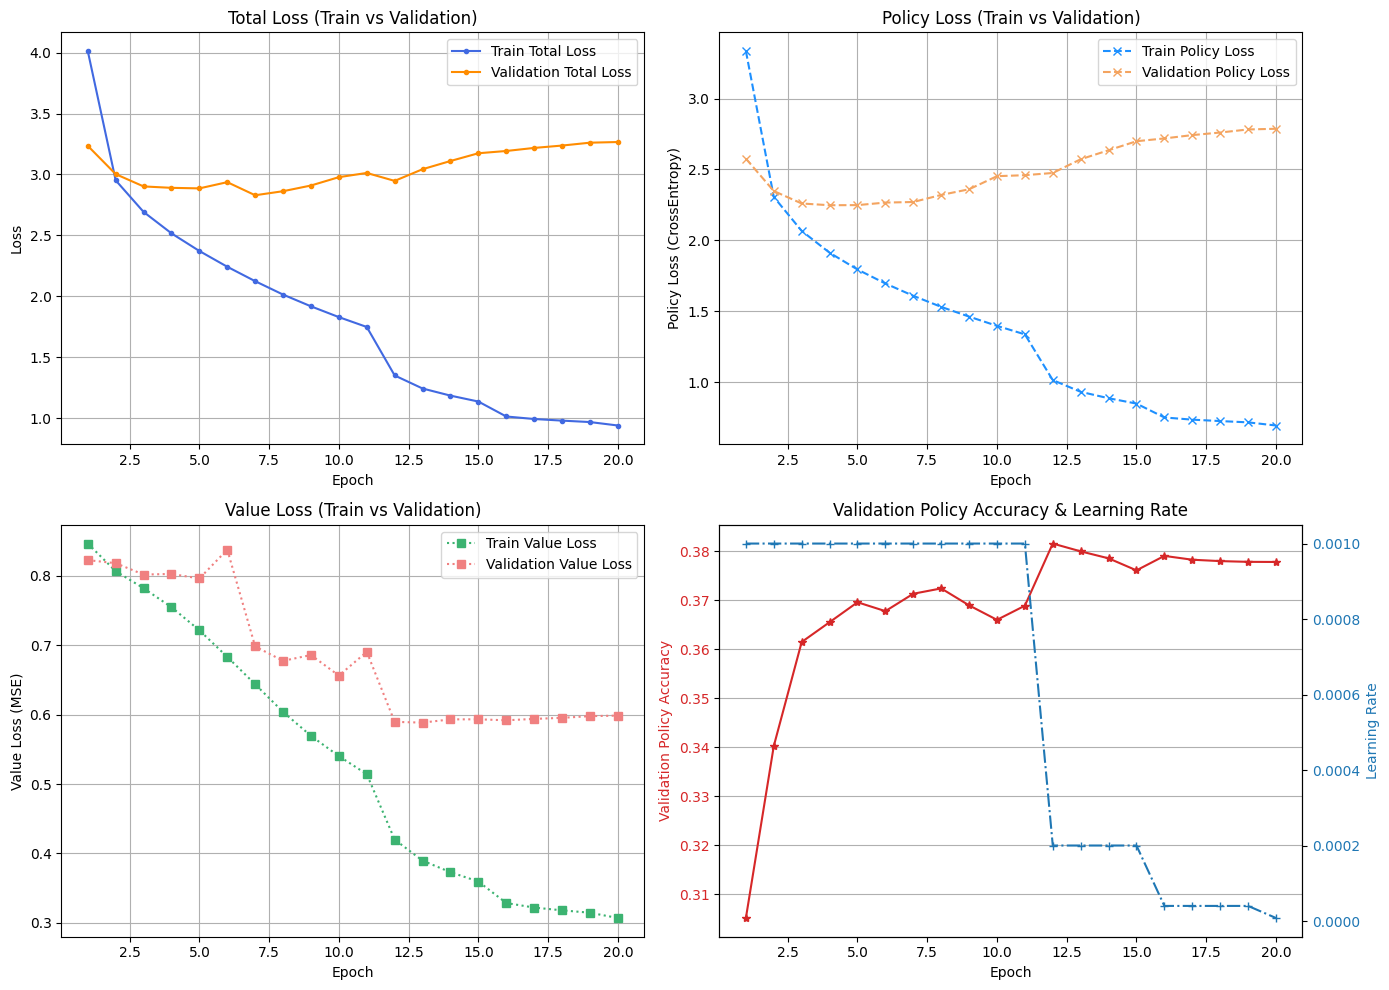

In [10]:
# ## Cell 9: Plot Training Graphs (Loss & Accuracy) 📈📉
# Visualize the training and validation progress. Seeing these curves helps understand learning dynamics and detect overfitting!

# %% {"cell_type": "code"}
if history['epoch']: # Check if training ran and history exists
    print("\n--- Plotting Training and Validation Progress ---")
    epochs_range = history['epoch']

    plt.figure(figsize=(14, 10)) # Larger figure size

    # --- Plot Total Loss ---
    plt.subplot(2, 2, 1) # 2 rows, 2 cols, 1st plot
    plt.plot(epochs_range, history['train_loss'], label='Train Total Loss', color='royalblue', marker='.')
    plt.plot(epochs_range, history['val_loss'], label='Validation Total Loss', color='darkorange', marker='.')
    plt.title('Total Loss (Train vs Validation)')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    # --- Plot Policy Loss ---
    plt.subplot(2, 2, 2) # 2 rows, 2 cols, 2nd plot
    plt.plot(epochs_range, history['train_policy_loss'], label='Train Policy Loss', color='dodgerblue', linestyle='--', marker='x')
    plt.plot(epochs_range, history['val_policy_loss'], label='Validation Policy Loss', color='sandybrown', linestyle='--', marker='x')
    plt.title('Policy Loss (Train vs Validation)')
    plt.xlabel('Epoch')
    plt.ylabel('Policy Loss (CrossEntropy)')
    plt.legend()
    plt.grid(True)

    # --- Plot Value Loss ---
    plt.subplot(2, 2, 3) # 2 rows, 2 cols, 3rd plot
    plt.plot(epochs_range, history['train_value_loss'], label='Train Value Loss', color='mediumseagreen', linestyle=':', marker='s')
    plt.plot(epochs_range, history['val_value_loss'], label='Validation Value Loss', color='lightcoral', linestyle=':', marker='s')
    plt.title('Value Loss (Train vs Validation)')
    plt.xlabel('Epoch')
    plt.ylabel('Value Loss (MSE)')
    plt.legend()
    plt.grid(True)

    # --- Plot Validation Policy Accuracy & Learning Rate ---
    ax1 = plt.subplot(2, 2, 4) # 2 rows, 2 cols, 4th plot
    color = 'tab:red'
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Validation Policy Accuracy', color=color)
    ax1.plot(epochs_range, history['val_policy_accuracy'], label='Validation Policy Accuracy', color=color, marker='*')
    ax1.tick_params(axis='y', labelcolor=color)
    ax1.grid(True, axis='y')

    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
    color = 'tab:blue'
    ax2.set_ylabel('Learning Rate', color=color)
    ax2.plot(epochs_range, history['lr'], label='Learning Rate', color=color, linestyle='-.', marker='+')
    ax2.tick_params(axis='y', labelcolor=color)

    plt.title('Validation Policy Accuracy & Learning Rate')
    # Add combined legend if needed, or rely on axis labels
    # fig.tight_layout() # For automatic layout adjustment

    plt.tight_layout() # Adjust subplot parameters for a tight layout
    plt.show()

else:
    print("\nNo training history found to plot.")



In [11]:
# ## Cell 10: Save Final Model and Mappings
# Save the final model state (potentially overwrite the 'best' model if you prefer the final state) and the necessary mappings.

# %% {"cell_type": "code"}
if 'model' in locals() and model is not None and 'move_to_int' in locals(): # Check if model exists and mappings were created
    # Save the final model state
    print(f"\nSaving final model state dict to: {MODEL_SAVE_PATH}")
    try:
        # <<<--- DataParallel Saving Modification --->>>
        if isinstance(model, nn.DataParallel):
            state_dict_to_save = model.module.state_dict()
            print("  Saving final state_dict from model.module (DataParallel active)")
        else:
            state_dict_to_save = model.state_dict()
            print("  Saving final state_dict from model (DataParallel not active)")
        # <<<-------------------------------------->>>
        torch.save(state_dict_to_save, MODEL_SAVE_PATH)
        print("  Final model saved successfully.")
    except Exception as e:
        print(f"  Error saving final model: {e}")

    # Save mappings (No changes needed here)
    print(f"Saving mappings to: {MAPPING_SAVE_PATH}")
    try:
        mappings = {
            'move_to_int': move_to_int,
            'int_to_move': int_to_move,
            'num_classes': num_classes
        }
        with open(MAPPING_SAVE_PATH, "wb") as f:
            pickle.dump(mappings, f)
        print("  Mappings saved successfully!")
    except Exception as e:
        print(f"  Error saving mappings: {e}")

    print("\n--- Saving Complete ---")
    # You might want to load the '_best.pth' model for prediction if you saved it earlier
    LOAD_BEST_MODEL_FOR_PREDICTION = True # Set to True to use the best saved model

else:
    print("\nSkipping final saving as model or mappings are not available.")
    LOAD_BEST_MODEL_FOR_PREDICTION = False


Saving final model state dict to: /kaggle/working/chess_model_v4_resnet_val.pth
  Saving final state_dict from model.module (DataParallel active)
  Final model saved successfully.
Saving mappings to: /kaggle/working/chess_mappings_v4.pkl
  Mappings saved successfully!

--- Saving Complete ---


In [12]:
# ## Cell 11: Prediction Setup
# Load the mappings and the desired model (either final or best based on validation) for inference.

# %% {"cell_type": "code"}
# --- Load Mappings ---
loaded_mappings = None
loaded_move_to_int = None
loaded_int_to_move = None
loaded_num_classes = None
try:
    print(f"\n--- Prediction Setup ---")
    print(f"Loading mappings from: {MAPPING_SAVE_PATH}")
    with open(MAPPING_SAVE_PATH, "rb") as f:
        loaded_mappings = pickle.load(f)
    loaded_move_to_int = loaded_mappings['move_to_int']
    loaded_int_to_move = loaded_mappings['int_to_move']
    loaded_num_classes = loaded_mappings['num_classes']
    print("Mappings loaded successfully.")
    print(f"  Number of move classes: {loaded_num_classes}")
except Exception as e:
    print(f"Error: Could not load mapping file from {MAPPING_SAVE_PATH}: {e}")
    loaded_mappings = None

# --- Setup Device ---
if torch.cuda.is_available():
    prediction_device = torch.device("cuda")
    print(f"Using GPU for prediction.")
else:
    prediction_device = torch.device("cpu")
    print("Using CPU for prediction.")

# --- Load Model ---
prediction_model = None
model_path_to_load = MODEL_SAVE_PATH # Default to final model

# Choose whether to load the best model based on validation loss
if LOAD_BEST_MODEL_FOR_PREDICTION:
     best_model_path = MODEL_SAVE_PATH.replace('.pth', '_best.pth')
     if os.path.exists(best_model_path):
         model_path_to_load = best_model_path
         print(f"Attempting to load best model from: {model_path_to_load}")
     else:
         print(f"Warning: Best model file '{best_model_path}' not found. Loading final model instead.")

if loaded_mappings:
    print(f"\nLoading model structure and weights from: {model_path_to_load}")
    try:
        # Re-initialize model structure (ensure parameters match saved model!)
        prediction_model = ChessModelV4(
            num_policy_classes=loaded_num_classes,
            num_res_blocks=NUM_RES_BLOCKS, # MUST match trained model
            num_channels=NUM_CHANNELS    # MUST match trained model
        )
        # Load the saved weights onto the correct device
        prediction_model.load_state_dict(torch.load(model_path_to_load, map_location=prediction_device))
        prediction_model.to(prediction_device)
        prediction_model.eval() # Set to evaluation mode!
        print("Model loaded successfully and set to evaluation mode.")
    except FileNotFoundError:
        print(f"Error: Model file not found at {model_path_to_load}.")
    except Exception as e:
        print(f"Error loading model state dict: {e}")
        print("Ensure the model definition (ResBlocks, Channels, etc.) matches the saved model!")
        prediction_model = None
else:
    print("\nSkipping model loading as mappings were not loaded.")

print("\n--- Prediction Setup Complete ---")


--- Prediction Setup ---
Loading mappings from: /kaggle/working/chess_mappings_v4.pkl
Mappings loaded successfully.
  Number of move classes: 1879
Using GPU for prediction.
Attempting to load best model from: /kaggle/working/chess_model_v4_resnet_val_best.pth

Loading model structure and weights from: /kaggle/working/chess_model_v4_resnet_val_best.pth

ChessModelV4 initialized:
  Input Channels: 18
  Residual Blocks: 9 x 128 channels
  Policy Head Flattened Size: 2048
  Value Head Flattened Size: 1024
  Output Policy Classes: 1879
Initializing model weights...
Weight initialization complete.
Model loaded successfully and set to evaluation mode.

--- Prediction Setup Complete ---


<ipython-input-12-4fb93e292539>:55: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  prediction_model.load_state_dict(torch.load(model_path_to_load, map_location=prediction_dev

In [13]:
# ## Cell 12: Prediction Function (V4)
# Takes a board state, uses the loaded V4 model to predict the best *legal* move based on the policy head, and also returns the value prediction.

# %% {"cell_type": "code"}
def prepare_input_v4(board: Board):
    """ Prepares a single board state for the V4 model """
    matrix = board_to_matrix_v4(board, flip=False) # No flip during standard prediction
    X_tensor = torch.tensor(matrix, dtype=torch.float32).unsqueeze(0) # Add batch dim [1, C, H, W]
    return X_tensor

def predict_move_v4(board: Board, model_to_use, device_to_use, int_to_move_map):
    """
    Predicts the best legal move using the V4 model.
    Returns: (best_legal_move_object, predicted_value)
    """
    if not model_to_use or not int_to_move_map:
        print("Error: Model or mappings not loaded in predict_move_v4.")
        return None, 0.0 # Return None move and neutral value

    # 1. Prepare Input
    X_tensor = prepare_input_v4(board).to(device_to_use)

    # 2. Get Model Output in Inference Mode
    predicted_value = 0.0
    best_legal_move_obj = None
    best_prob = -1.0

    with torch.no_grad(): # Ensure no gradients are calculated
        try:
            policy_logits, value_output = model_to_use(X_tensor)
            predicted_value = value_output.item() # Get scalar value prediction

            # 3. Process Policy Output
            policy_logits = policy_logits.squeeze(0) # Remove batch dim -> shape [num_classes]
            probabilities = torch.softmax(policy_logits, dim=0).cpu().numpy() # Convert to probabilities

            # 4. Get Legal Moves
            legal_moves = list(board.legal_moves)
            if not legal_moves:
                 # print("No legal moves available.")
                 return None, predicted_value # Game likely over

            legal_moves_uci_set = {move.uci() for move in legal_moves}

            # 5. Find Best *Legal* Move based on Predicted Probabilities
            candidate_moves = {} # Store legal moves and their probabilities
            for i, prob in enumerate(probabilities):
                 move_uci = int_to_move_map.get(i)
                 if move_uci in legal_moves_uci_set:
                     candidate_moves[move_uci] = prob

            if candidate_moves:
                 # Find the UCI string of the highest probability legal move
                 best_legal_move_uci = max(candidate_moves, key=candidate_moves.get)
                 best_prob = candidate_moves[best_legal_move_uci]

                 # Find the corresponding Move object (needed by board.push)
                 for move in legal_moves:
                      if move.uci() == best_legal_move_uci:
                           best_legal_move_obj = move
                           break
                 # print(f"  Model suggests: {best_legal_move_uci} (Prob: {best_prob:.4f}, Value: {predicted_value:.3f})")
            else:
                 # This case should be rare if the model is trained reasonably
                 print("Warning: Model assigned zero probability to all legal moves! Picking random.")
                 best_legal_move_obj = random.choice(legal_moves)
                 # print(f"  Falling back to random move: {best_legal_move_obj.uci()}")

        except Exception as e:
            print(f"Error during model prediction: {e}")
            # Fallback: pick random move if prediction fails
            legal_moves = list(board.legal_moves)
            if legal_moves:
                print("Picking random legal move due to prediction error.")
                best_legal_move_obj = random.choice(legal_moves)

    # 6. Final Checks and Return
    if not best_legal_move_obj and board.is_game_over():
        # print(f"Game is over: {board.result()}")
        return None, predicted_value
    elif not best_legal_move_obj: # Fallback if something went very wrong
        print("Critical Warning: No move selected, but game not over. Picking random.")
        legal_moves = list(board.legal_moves)
        if legal_moves: best_legal_move_obj = random.choice(legal_moves)

    # Return the Move object and the predicted value
    return best_legal_move_obj, predicted_value

print("Prediction function predict_move_v4 defined.")



Prediction function predict_move_v4 defined.


In [ ]:
# ## Cell 13: Example Prediction with SVG Output
# Let's watch our trained AI play a few moves against itself (or follow a sequence). We'll display the board using SVG after each move.

# %% {"cell_type": "code"}
if prediction_model and loaded_mappings:
    # Initialize a board
    board = Board()
    print("\n--- Starting Prediction Example with SVG Output ---")

    MAX_PREDICTION_MOVES = 200 # Play N moves
    move_counter = 0

    try:
        # Display initial board
        print("Initial Board:")
        display(SVG(board._repr_svg_())) # Explicitly display SVG

        while move_counter < MAX_PREDICTION_MOVES:
            move_counter += 1
            current_player = "White" if board.turn else "Black"
            print(f"\n--- Move {board.fullmove_number}. {'...' if not board.turn else ''}{current_player} to Play ---")

            # Check if game is over
            if board.is_game_over(claim_draw=True): # Check for draws too
                print(f"Game Over! Result: {board.result(claim_draw=True)}")
                break

            # Get AI's prediction
            ai_move, predicted_val = predict_move_v4(board, prediction_model, prediction_device, loaded_int_to_move)

            if ai_move:
                move_uci = ai_move.uci()
                print(f"AI suggests move: {move_uci} (Predicted Value: {predicted_val:.3f})")
                board.push(ai_move) # Make the move on the board

                # Display board after move using SVG
                print(f"\nBoard after {board.fullmove_number-1 if not board.turn else board.fullmove_number}.{'..' if board.turn else ''}{move_uci}:")
                display(SVG(board._repr_svg_()))

            else:
                print(f"AI could not suggest a valid move for {current_player}.")
                # Check game over status again if no move was suggested
                if board.is_game_over(claim_draw=True):
                     print(f"Game Over! Result: {board.result(claim_draw=True)}")
                break # Stop simulation

    except Exception as e:
         print(f"\nAn unexpected error occurred during the prediction simulation: {e}")
         import traceback
         traceback.print_exc() # Print detailed traceback for debugging

    print("\n--- Prediction Example Finished ---")
    print("\nFinal Board State:")
    display(SVG(board._repr_svg_())) # Display final board
    if board.is_game_over(claim_draw=True):
         print(f"Final Result: {board.result(claim_draw=True)}")

else:
    print("\nPrediction model or mappings not loaded. Skipping prediction example.")


